# Melanoma Classification using CNN

This notebook implements a Convolutional Neural Network (CNN) for melanoma detection using processed images.

In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices()}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## 1. Load and Prepare Data

We'll load the processed images for melanoma classification.

In [34]:
# Set paths
base_path = '../'
processed_dir = os.path.join(base_path, 'working', 'processed_images')
melanoma_dir = os.path.join(processed_dir, 'melanoma')
non_melanoma_dir = os.path.join(processed_dir, 'non_melanoma')

In [36]:
# Function to load images from directories
def load_images_from_directory(directory, label):
    images = []
    labels = []

    if not os.path.exists(directory):
        print(f"Warning: Directory {directory} does not exist!")
        return images, labels

    for filename in os.listdir(directory):
        if filename.endswith('.jpg'):
            img_path = os.path.join(directory, filename)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (224, 224))  # Ensure consistent size
                    images.append(img)
                    labels.append(label)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    return images, labels


# Load melanoma and non-melanoma images
print("Loading melanoma images...")
melanoma_images, melanoma_labels = load_images_from_directory(melanoma_dir, 1)

print("Loading non-melanoma images...")
non_melanoma_images, non_melanoma_labels = load_images_from_directory(
    non_melanoma_dir, 0)

# Combine datasets
X = np.array(melanoma_images + non_melanoma_images)
y = np.array(melanoma_labels + non_melanoma_labels)

# Print dataset information
print(f"Dataset loaded: {X.shape[0]} images")
print(f"Melanoma images: {len(melanoma_images)}")
print(f"Non-melanoma images: {len(non_melanoma_images)}")

# Technically this should be done in data augmentation and pre-processing but for now we are lazy
# Reshape and normalize images for CNN input
X = X.reshape(-1, 224, 224, 1).astype('float32') / 255.0

Loading melanoma images...
Loading non-melanoma images...
Dataset loaded: 25331 images
Melanoma images: 4522
Non-melanoma images: 20809


In [41]:
import albumentations as A
import random
from sklearn.utils import shuffle

# Balancing the data set with the same number of melanoma samples since we'll augment them
target_samples = 4522

print(f"Original dataset - Melanoma: {len(melanoma_images)}, Non-melanoma: {len(non_melanoma_images)}")

# # 1. Subsample non-melanoma images to reduce class imbalance
# non_melanoma_indices = list(range(len(non_melanoma_images)))
# random.seed(42)
# random.shuffle(non_melanoma_indices)
# non_melanoma_indices = non_melanoma_indices[:target_samples]
# non_melanoma_images_balanced = [non_melanoma_images[i] for i in non_melanoma_indices]
# non_melanoma_labels_balanced = [non_melanoma_labels[i] for i in non_melanoma_indices]

# print(f"After subsampling - Non-melanoma: {len(non_melanoma_images_balanced)}")

# # 2. Create augmentation pipeline
# augmentation = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.RandomRotate90(p=0.5),
#     A.RandomBrightnessContrast(p=0.5),
#     A.Rotate(limit=30, p=0.5),
#     A.GaussianBlur(blur_limit=(3, 7), p=0.3),
#     A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=45, p=0.5),
#     A.GridDistortion(p=0.3),
#     A.ElasticTransform(p=0.3),
# ])

# melanoma_images_augmented = melanoma_images.copy()
# melanoma_labels_augmented = melanoma_labels.copy()

# print("Augmenting melanoma images...")

# # Generate augmented images for the melanoma class to balance dataset
# num_augmentations_needed = target_samples - len(melanoma_images)
# images_to_augment = random.choices(melanoma_images, k=num_augmentations_needed)

# for img in images_to_augment:
#     img_uint8 = img.astype(np.uint8)
#     augmented = augmentation(image=img_uint8)
#     melanoma_images_augmented.append(augmented['image'])
#     melanoma_labels_augmented.append(1)

# print(f"After augmentation - Melanoma: {len(melanoma_images_augmented)}")

# Create balanced dataset
X_balanced = np.array(melanoma_images + non_melanoma_images[:target_samples])
y_balanced = np.array(melanoma_labels + non_melanoma_labels[:target_samples])

# Shuffle the data
X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=42)

# Reshape and normalize images for CNN input
X_balanced = X_balanced.reshape(-1, 224, 224, 1).astype('float32') / 255.0

print(f"Balanced dataset - Total: {X_balanced.shape[0]} images")
print(f"Class distribution - Melanoma: {np.sum(y_balanced == 1)}, Non-melanoma: {np.sum(y_balanced == 0)}")

# Replace original X and y with balanced dataset
X, y = X_balanced, y_balanced


Original dataset - Melanoma: 4522, Non-melanoma: 20809
Balanced dataset - Total: 9044 images
Class distribution - Melanoma: 4522, Non-melanoma: 4522


In [ ]:
# Split data into training, validation, and test sets
# First split: 80% training+validation, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Second split: 80% training, 20% validation (from the training+validation set)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

# Check class distribution in each set
print(f"Training set - Melanoma: {np.sum(y_train == 1)}, Non-melanoma: {np.sum(y_train == 0)}")
print(f"Validation set - Melanoma: {np.sum(y_val == 1)}, Non-melanoma: {np.sum(y_val == 0)}")
print(f"Test set - Melanoma: {np.sum(y_test == 1)}, Non-melanoma: {np.sum(y_test == 0)}")

Training set: 5788 images
Validation set: 1447 images
Test set: 1809 images
Training set - Melanoma: 2894, Non-melanoma: 2894
Validation set - Melanoma: 724, Non-melanoma: 723
Test set - Melanoma: 904, Non-melanoma: 905


## 2. Build CNN Model

We'll create a CNN model architecture suitable for melanoma classification.

In [43]:
def build_cnn_model(input_shape=(224, 224, 1)):
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Dense layers
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    return model

# Build the model
model = build_cnn_model()
model.summary()


c:\Users\Priya\Downloads\kaggle\melanoma-project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 25,979,873 (99.11 MB)

 Trainable params: 25,978,465 (99.10 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [44]:
# Set up callbacks for training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    ModelCheckpoint('../working/melanoma_model.h5', monitor='val_auc', mode='max', save_best_only=True, verbose=1)
]

# Calculate class weights to handle imbalance
class_weight = {
    0: 1.0,
    1: len(y_train[y_train == 0]) / len(y_train[y_train == 1]) if np.sum(y_train == 1) > 0 else 1.0
}
print(f"Class weights: {class_weight}")

Class weights: {0: 1.0, 1: 1.0}


In [45]:
# Train the model
batch_size = 32
epochs = 20

history = model.fit(
    X_train, y_train,
    batch_size=batch_size, 
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1
)

Epoch 1/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6780 - auc: 0.7440 - loss: 0.7073
Epoch 1: val_auc improved from -inf to 0.50000, saving model to ../working/melanoma_model.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.6782 - auc: 0.7443 - loss: 0.7069 - val_accuracy: 0.5003 - val_auc: 0.5000 - val_loss: 12.5865 - learning_rate: 1.0000e-04
Epoch 2/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7812 - auc: 0.8567 - loss: 0.4898
Epoch 2: val_auc improved from 0.50000 to 0.51248, saving model to ../working/melanoma_model.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.7813 - auc: 0.8567 - loss: 0.4897 - val_accuracy: 0.5038 - val_auc: 0.5125 - val_loss: 12.6976 - learning_rate: 1.0000e-04
Epoch 3/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8013 - auc: 0.8828 - loss: 0.4400
Epoch 3: val_auc improved from 0.51248 to 0.78860, saving model to ../working/melanoma_model.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.8013 - auc: 0.8828 - loss: 0.4400 - val_accuracy: 0.7374 - val_auc: 0.7886 - val_loss: 0.8397 - learning_rate: 1.0000e-04
Epoch 4/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8148 - auc: 0.8977 - loss: 0.4150
Epoch 4: val_auc improved from 0.78860 to 0.87149, saving model to ../working/melanoma_model.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.8148 - auc: 0.8977 - loss: 0.4149 - val_accuracy: 0.7326 - val_auc: 0.8715 - val_loss: 0.7922 - learning_rate: 1.0000e-04
Epoch 5/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8297 - auc: 0.9174 - loss: 0.3688
Epoch 5: val_auc improved from 0.87149 to 0.87788, saving model to ../working/melanoma_model.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.8298 - auc: 0.9174 - loss: 0.3687 - val_accuracy: 0.7498 - val_auc: 0.8779 - val_loss: 0.8366 - learning_rate: 1.0000e-04
Epoch 6/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8661 - auc: 0.9392 - loss: 0.3166
Epoch 6: val_auc did not improve from 0.87788
181/181 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.8661 - auc: 0.9392 - loss: 0.3165 - val_accuracy: 0.6372 - val_auc: 0.8321 - val_loss: 1.5190 - learning_rate: 1.0000e-04
Epoch 7/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8708 - auc: 0.9464 - loss: 0.2962
Epoch 7: val_auc did not improve from 0.87788
181/181 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.8709 - auc: 0.9464 - loss: 0.2962 - val_accuracy: 0.7332 - val_auc: 0.8601 - val_loss: 1.0781 - learning_rate: 1.0000e-04
Epoch 8/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8819 - auc: 0.9573 - loss: 0.2641
Epoch 8: val_auc did not improve from 0.87788
181/181 ━━━━━━━━━━━━━━━━━━━━ 39

## 3. Evaluate Model Performance

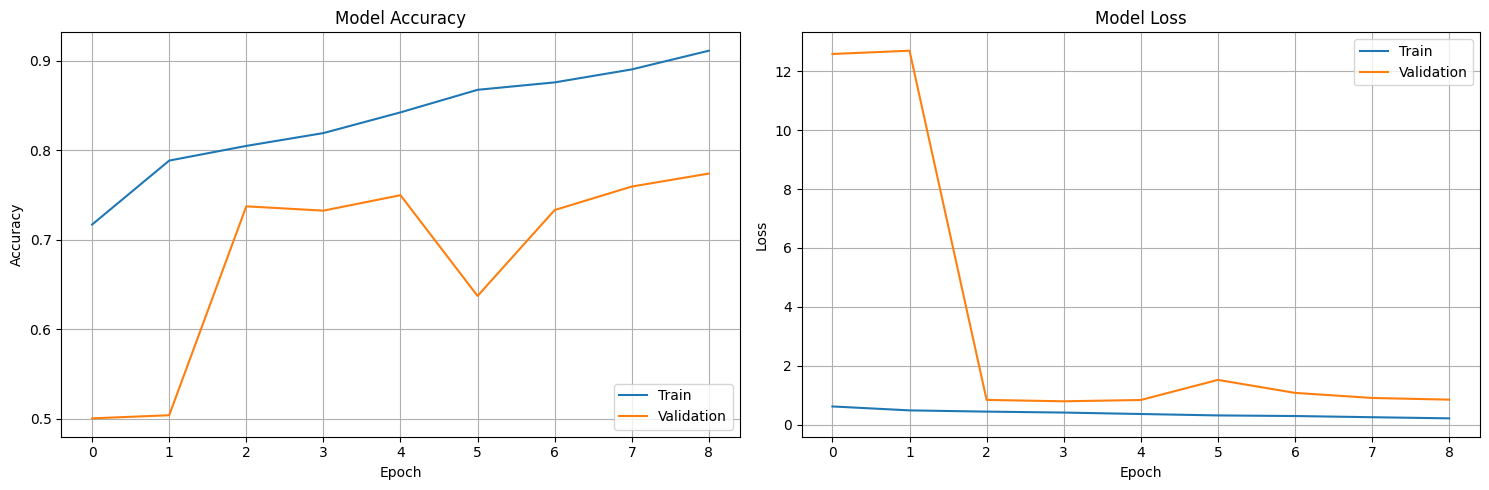

In [46]:
# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

In [47]:
# Evaluate on test set
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Make predictions on test set
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Melanoma', 'Melanoma']))

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 267ms/step - accuracy: 0.7336 - auc: 0.8736 - loss: 0.7881
Test accuracy: 0.7330
Test AUC: 0.8781
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 306ms/step

Classification Report:
              precision    recall  f1-score   support

Non-Melanoma       0.65      0.99      0.79       905
    Melanoma       0.98      0.47      0.64       904

    accuracy                           0.73      1809
   macro avg       0.82      0.73      0.71      1809
weighted avg       0.82      0.73      0.71      1809


Confusion Matrix:
[[898   7]
 [476 428]]


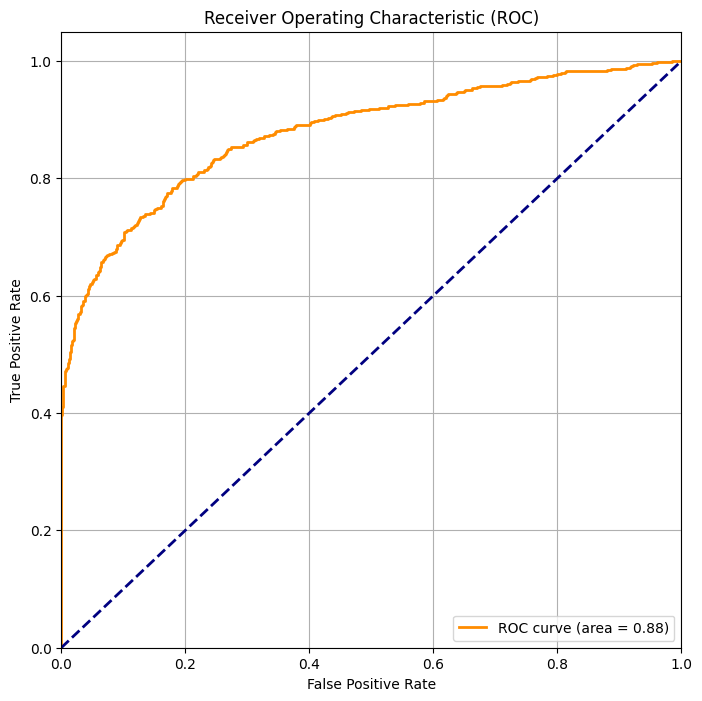

In [48]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

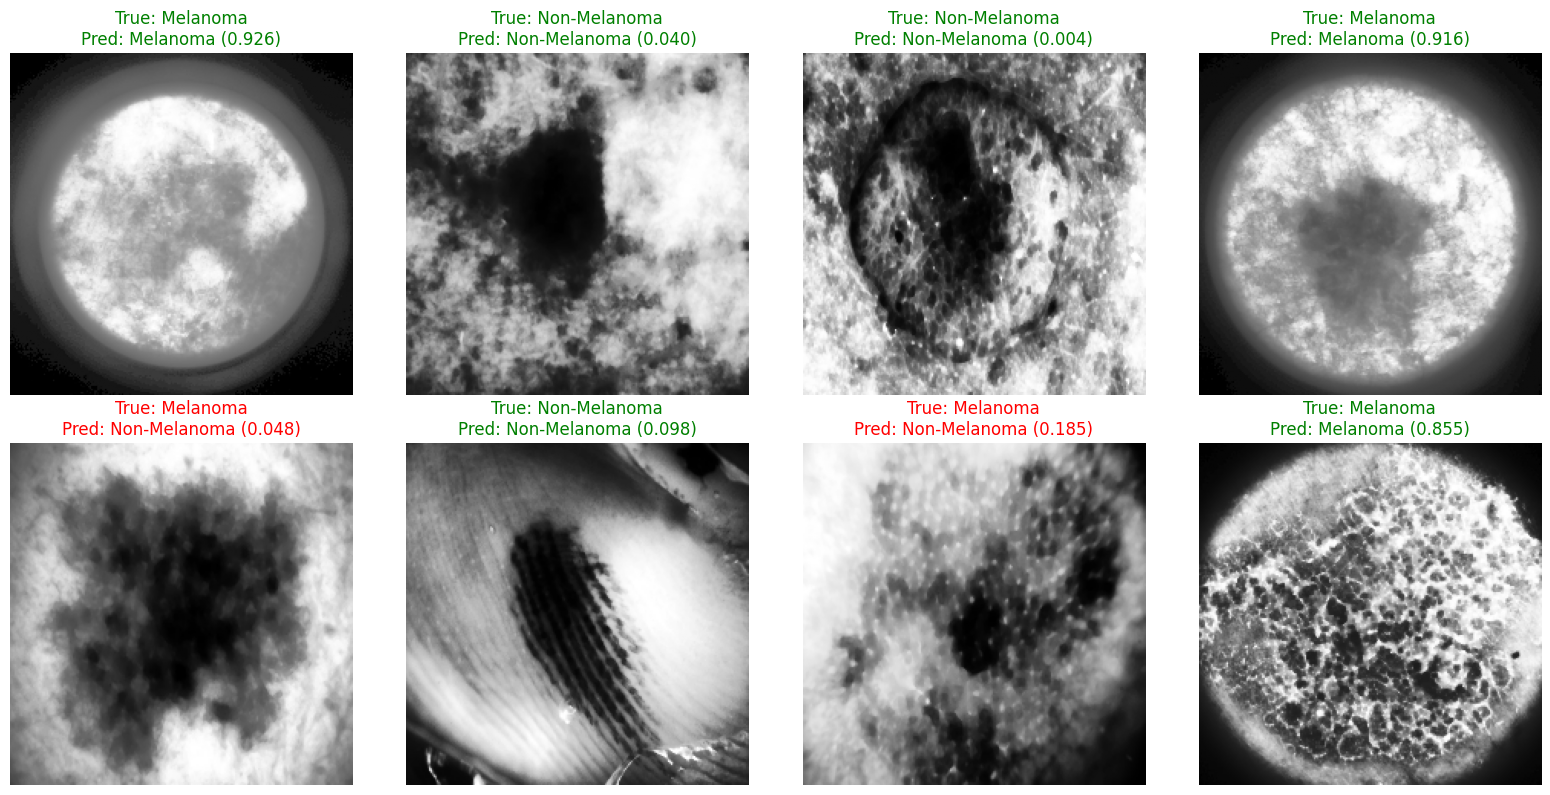

In [49]:
# Visualize some predictions
def visualize_predictions(X, y_true, y_pred, y_pred_proba, num_samples=8):
    # Select random samples
    indices = np.random.choice(range(len(y_true)), min(num_samples, len(y_true)), replace=False)
    
    # Create figure
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        if i >= num_samples:
            break
            
        # Get image and labels
        img = X[idx].reshape(224, 224)
        true_label = y_true[idx]
        pred_label = y_pred[idx]
        prob = y_pred_proba[idx][0]
        
        # Determine text color based on prediction correctness
        color = 'green' if true_label == pred_label else 'red'
        
        # Plot image
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"True: {'Melanoma' if true_label == 1 else 'Non-Melanoma'}\n" +
                        f"Pred: {'Melanoma' if pred_label == 1 else 'Non-Melanoma'} ({prob:.3f})",
                        color=color)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(X_test, y_test, y_pred, y_pred_proba)

## 4. Save Model and Results

In [50]:
# Save model
model_path = '../working/melanoma_cnn_final_6.h5'
model.save(model_path)
print(f"Model saved to {model_path}")

# Save test results
results = {
    'accuracy': float(test_acc),
    'auc': float(test_auc),
    'loss': float(test_loss)
}

import json
with open('../working/model_results.json', 'w') as f:
    json.dump(results, f)
print("Results saved to ../working/model_results.json")

Model saved to ../working/melanoma_cnn_final_6.h5
Results saved to ../working/model_results.json
